# Predicting Diabetes

## Contents

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [2]:
# Importing the data
nhgh = pd.read_csv('./nhgh.tsv', sep='\t')

In [3]:
# First look at dataset
display(nhgh.head())

display(nhgh.shape)

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79


(6795, 20)

In [4]:
# Checking for inappropriate datatypes
nhgh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6795 entries, 0 to 6794
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   seqn     6795 non-null   int64  
 1   sex      6795 non-null   object 
 2   age      6795 non-null   float64
 3   re       6795 non-null   object 
 4   income   6475 non-null   object 
 5   tx       6795 non-null   int64  
 6   dx       6795 non-null   int64  
 7   wt       6795 non-null   float64
 8   ht       6795 non-null   float64
 9   bmi      6795 non-null   float64
 10  leg      6564 non-null   float64
 11  arml     6616 non-null   float64
 12  armc     6607 non-null   float64
 13  waist    6556 non-null   float64
 14  tri      6314 non-null   float64
 15  sub      5824 non-null   float64
 16  gh       6795 non-null   float64
 17  albumin  6706 non-null   float64
 18  bun      6706 non-null   float64
 19  SCr      6706 non-null   float64
dtypes: float64(14), int64(3), object(3)
memory usage: 1.

Income can possibly be represented by a numeric datatype

In [5]:
# Checking for duplicate respondents
nhgh[nhgh.duplicated(subset='seqn', keep=False)]

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr


In [6]:
# Checking unique values / value counts of sex column
nhgh['sex'].value_counts()

female    3423
male      3372
Name: sex, dtype: int64

In [7]:
# Checking unique values / value counts of race/ethnicity column
nhgh['re'].value_counts()

Non-Hispanic White                   3117
Mexican American                     1366
Non-Hispanic Black                   1217
Other Hispanic                        706
Other Race Including Multi-Racial     389
Name: re, dtype: int64

In [8]:
# Checking unique values / value counts of income column
nhgh['income'].value_counts()

>= 100000         877
[25000,35000)     845
[35000,45000)     610
[75000,100000)    564
[20000,25000)     563
[10000,15000)     531
[45000,55000)     522
[15000,20000)     456
[55000,65000)     376
[5000,10000)      315
[65000,75000)     274
[0,5000)          235
> 20000           232
< 20000            75
Name: income, dtype: int64

In [9]:
# Defining functions to map income column into lower_bound_income and upper_bound_income
def lower_bound_income(income):
    if income is not None and not isinstance(income, float):
        if ',' in income:
            return int(income.split(',')[0][1:])
        elif '> 20000' in income:
            return int(income[2:]) + 1
        elif '=' in income:
            return int(income[3:])
        elif '<' in income:
            return 0
    else:
        return np.nan
    
def upper_bound_income(income):
    if income is not None and not isinstance(income, float):
        if ',' in income:
            return int(income.split(',')[1][:-1]) - 1
        elif '> 20000' in income:
            return 500000
        elif '=' in income:
            return 500000
        elif '<' in income:
            return int(income[2:]) - 1
    else:
        return np.nan

In [10]:
# Map income column into lower_bound_income and upper_bound_income
nhgh['income_lower_bound'] = nhgh['income'].map(lower_bound_income)
nhgh['income_upper_bound'] = nhgh['income'].map(upper_bound_income)

In [11]:
# Doing a sanity check for the descriptive statistics of numerical attributes
nhgh.describe()

,seqn,age,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr,income_lower_bound,income_upper_bound
count,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6795.000000,6564.000000,6616.000000,6607.000000,6556.000000,6314.000000,5824.000000,6795.000000,6706.000000,6706.000000,6706.000000,6475.000000,6475.000000
mean,56872.080500,44.285700,0.091832,0.134511,79.370625,167.042958,28.321741,38.409324,36.874607,32.485152,96.254149,18.787726,19.961556,5.676586,4.273621,12.917686,0.878627,40784.591815,120247.819923
std,3043.535776,20.594593,0.288810,0.341225,21.930903,10.264984,6.950110,3.876902,2.781616,5.297660,17.059193,8.319393,8.369083,0.964700,0.326545,5.717571,0.445238,31148.232036,174424.532423
min,51624.000000,12.000000,0.000000,0.000000,28.000000,123.300000,13.180000,20.400000,24.800000,16.800000,52.000000,2.600000,3.800000,4.000000,2.500000,1.000000,0.140000,0.000000,4999.000000
25%,54245.500000,25.666667,0.000000,0.000000,64.000000,159.600000,23.430000,36.000000,35.000000,28.850000,83.500000,12.000000,13.000000,5.200000,4.100000,9.000000,0.700000,20000.000000,24999.000000
50%,56873.000000,43.750000,0.000000,0.000000,76.300000,166.600000,27.290000,38.400000,36.800000,32.100000,95.300000,17.900000,19.400000,5.500000,4.300000,12.000000,0.830000,25000.000000,44999.000000
75%,59510.500000,61.333333,0.000000,0.000000,91.100000,174.500000,31.880000,41.000000,38.800000,35.600000,106.900000,25.000000,26.200000,5.800000,4.500000,15.000000,0.980000,65000.000000,99999.000000
max,62160.000000,80.000000,1.000000,1.000000,239.400000,202.700000,84.870000,50.600000,47.000000,61.000000,179.000000,41.100000,40.400000,16.400000,5.300000,90.000000,15.660000,100000.000000,500000.000000


Reference Ranges:
- Alb: 3.4-5.4 g/dL
- BUN: 6-24 mg/dL
- Creatinine: 0.6-1.4 mg/dL

# Exploratory Data Analysis

In [12]:
# Create 'diabetes' classification
nhgh['diabetes'] = nhgh['gh'].map(lambda x: 'gh >= 6.5' if x >= 6.5 else 'gh < 6.5')

# Drop unnecessary columns for EDA / machine learning
nhgh = nhgh.drop(columns=['seqn', 'income'])

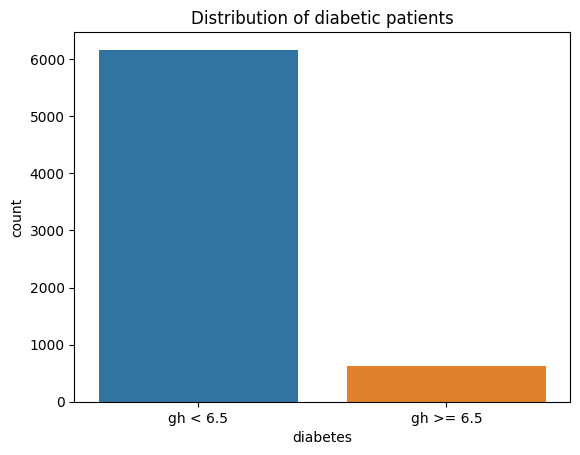

In [13]:
# Countplot for  target variable (gh >= 6.5 or not)
sns.countplot(data=nhgh, x='diabetes')
plt.title('Distribution of diabetic patients')
plt.show()

We can see that there is a major class imbalance, with >90% of the patients having no diabetes. We might need to apply undersampling/oversampling techniques later to address this class imbalance.

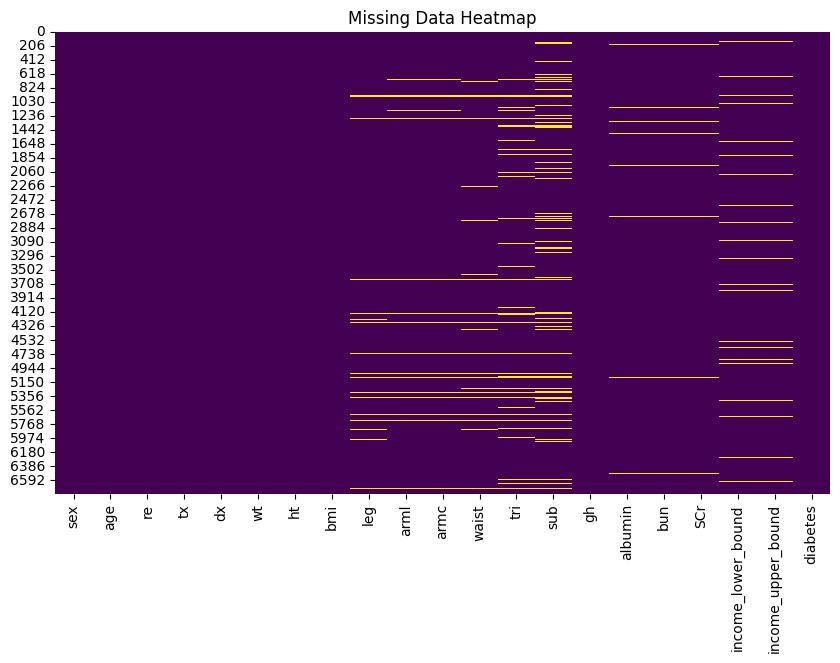

In [14]:
# Generating a heatmap to visualize pattern of missing data
plt.figure(figsize=(10, 6))
sns.heatmap(nhgh.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [15]:
# Generating percentage of missing values for each column
missing_percentage = (nhgh.isnull().sum() / len(nhgh)) * 100
missing_percentage

sex                    0.000000
age                    0.000000
re                     0.000000
tx                     0.000000
dx                     0.000000
wt                     0.000000
ht                     0.000000
bmi                    0.000000
leg                    3.399558
arml                   2.634290
armc                   2.766740
waist                  3.517292
tri                    7.078734
sub                   14.289919
gh                     0.000000
albumin                1.309787
bun                    1.309787
SCr                    1.309787
income_lower_bound     4.709345
income_upper_bound     4.709345
diabetes               0.000000
dtype: float64

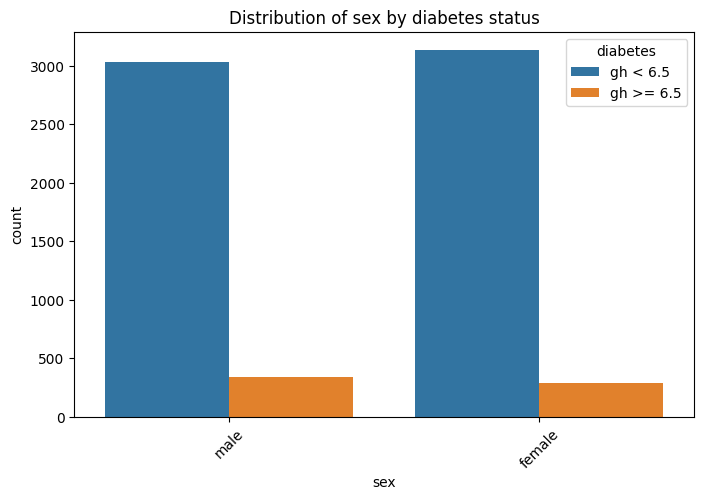

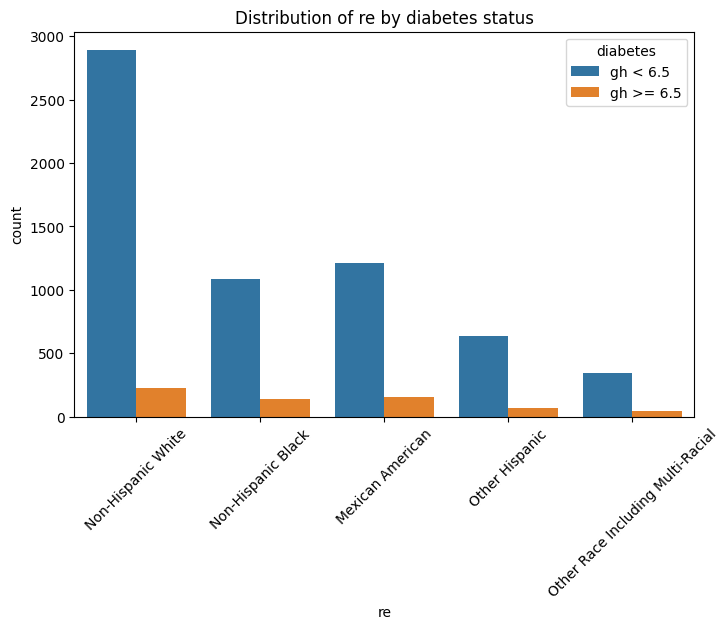

In [16]:
# Explore the distribution of categorical variables
for column in nhgh.select_dtypes(include=['object']):
    if column != 'diabetes':
        plt.figure(figsize=(8, 5))
        sns.countplot(data=nhgh, x=column, hue='diabetes')
        plt.title(f'Distribution of {column} by diabetes status')
        plt.xticks(rotation=45)
        plt.show()

In [17]:
# Percentage of diabetic patients grouped by racial category
nhgh.groupby('re')['diabetes'].value_counts(normalize=True)

re                                 diabetes 
Mexican American                   gh < 6.5     0.885798
                                   gh >= 6.5    0.114202
Non-Hispanic Black                 gh < 6.5     0.889071
                                   gh >= 6.5    0.110929
Non-Hispanic White                 gh < 6.5     0.927815
                                   gh >= 6.5    0.072185
Other Hispanic                     gh < 6.5     0.905099
                                   gh >= 6.5    0.094901
Other Race Including Multi-Racial  gh < 6.5     0.884319
                                   gh >= 6.5    0.115681
Name: diabetes, dtype: float64

- Percentage of male vs female patients with diabetes are quite similar.
- Percentage of diabetic patients quite similar across the board for different racial categories, perhaps slightly lower in non-hispanic white.

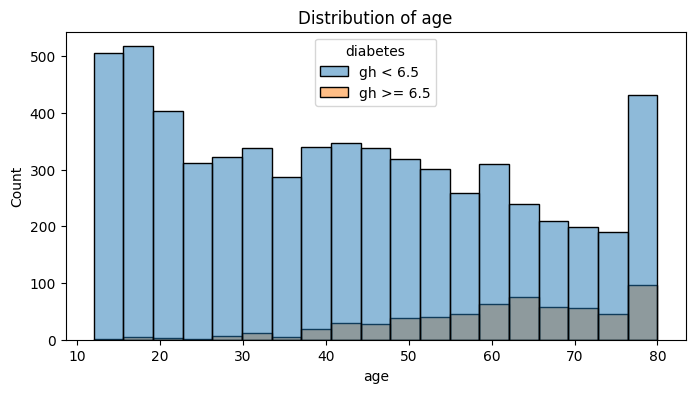

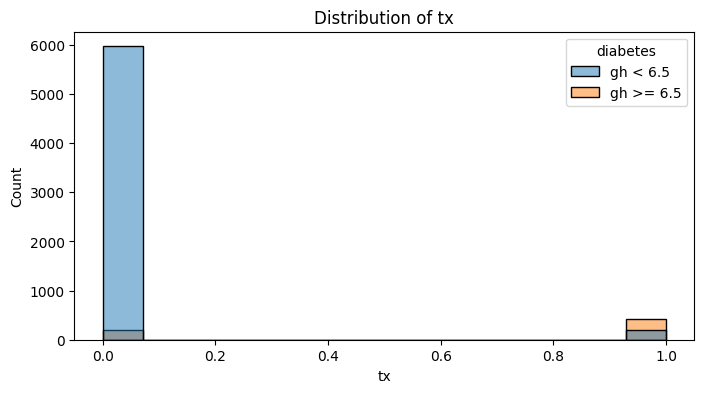

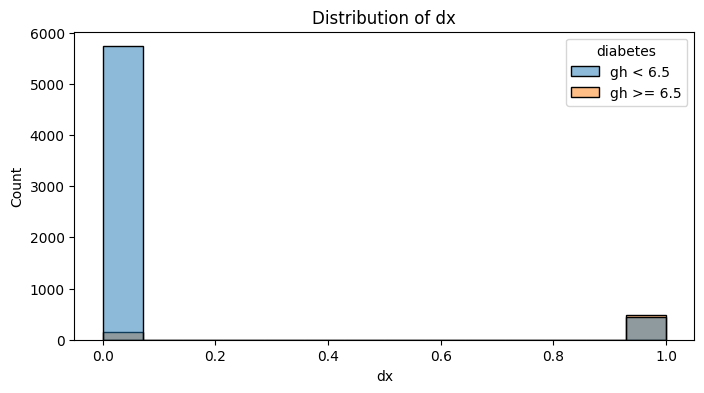

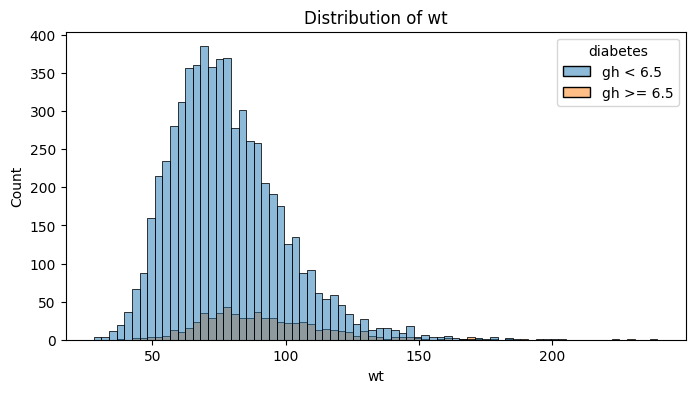

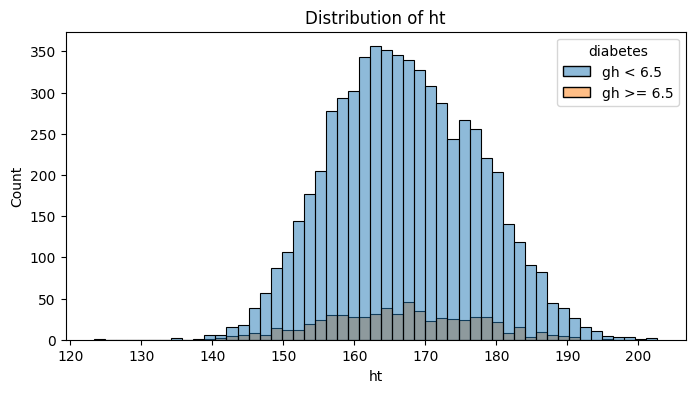

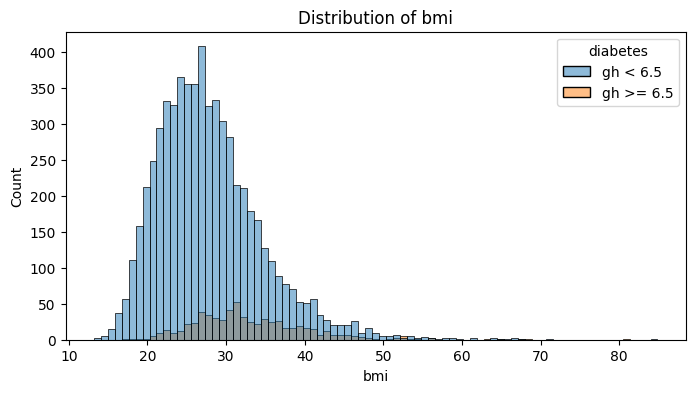

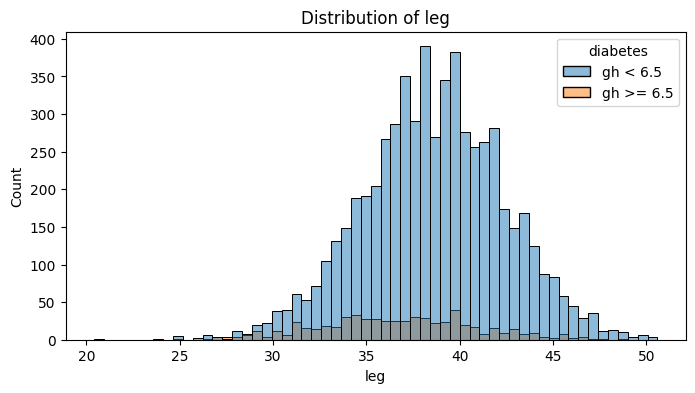

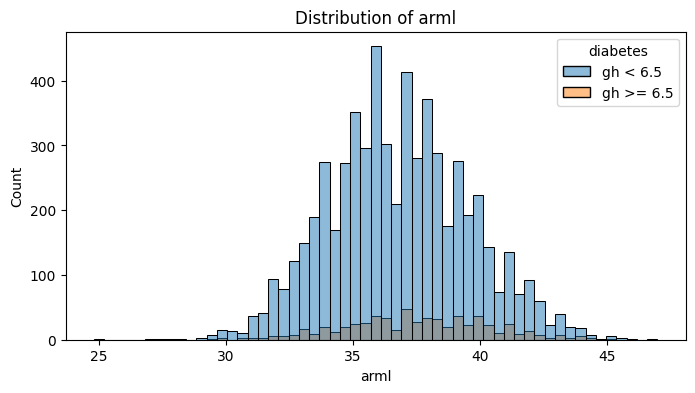

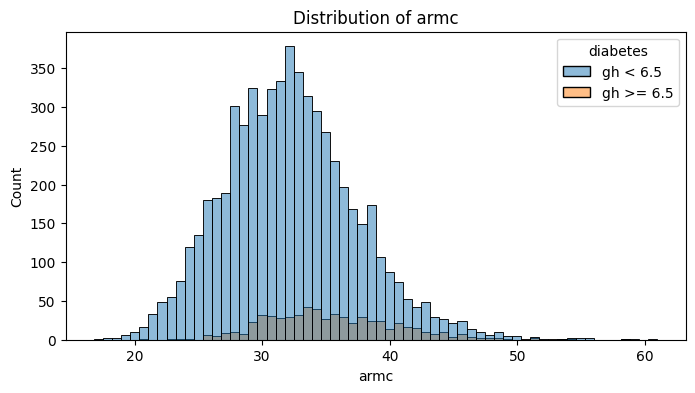

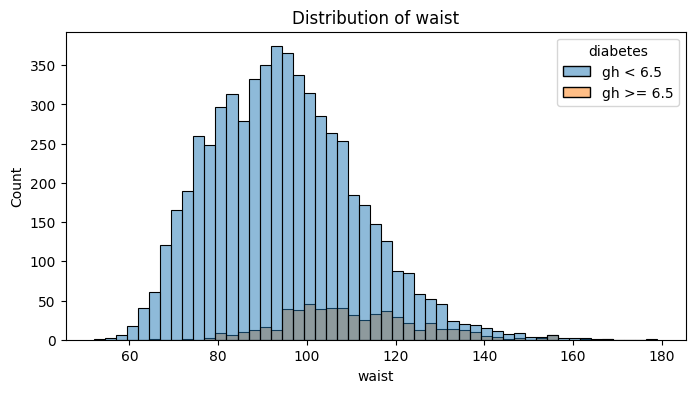

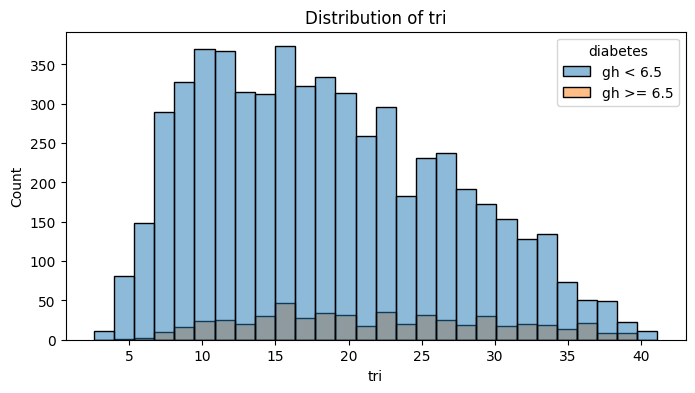

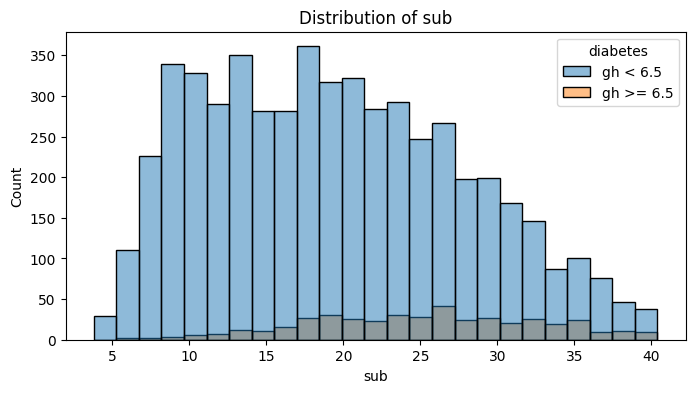

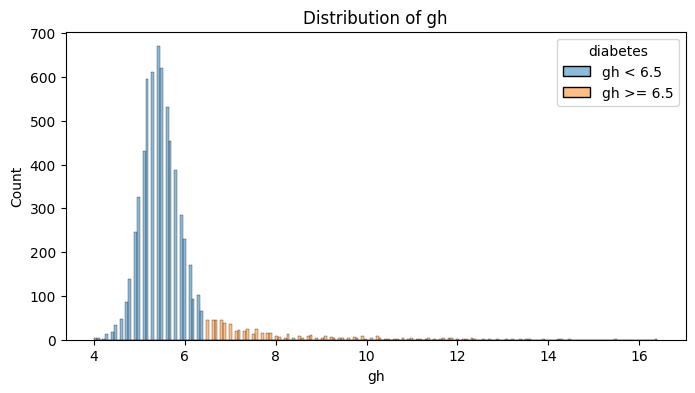

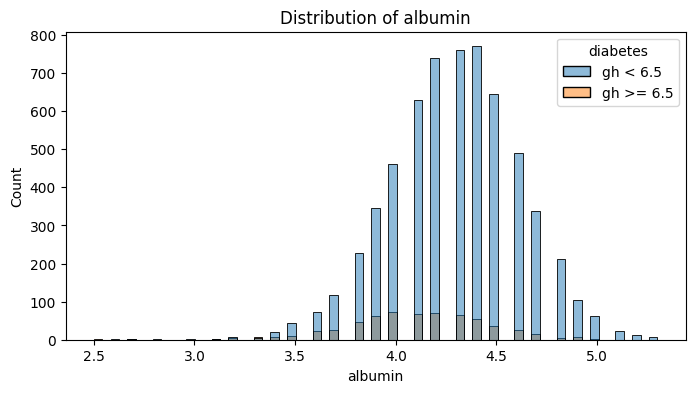

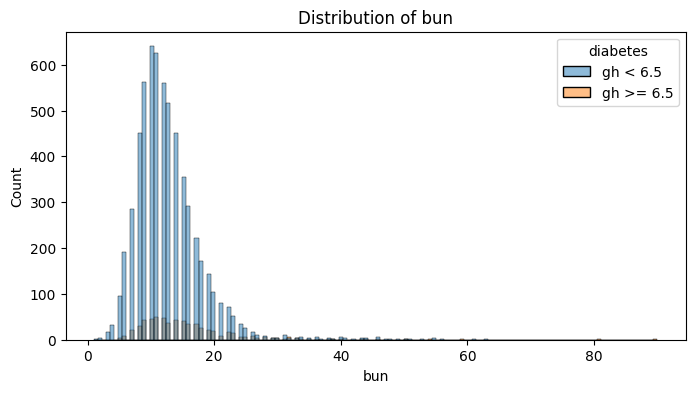

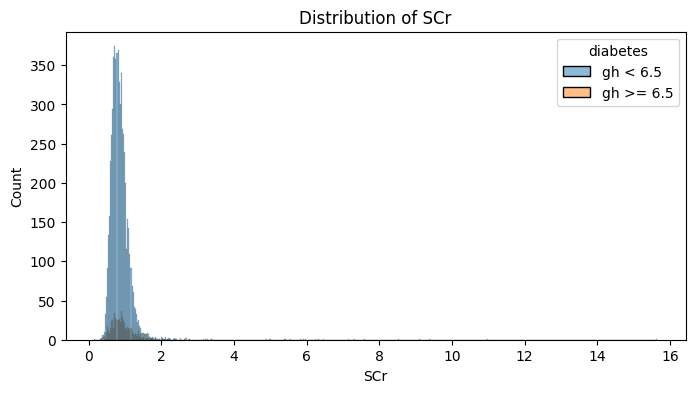

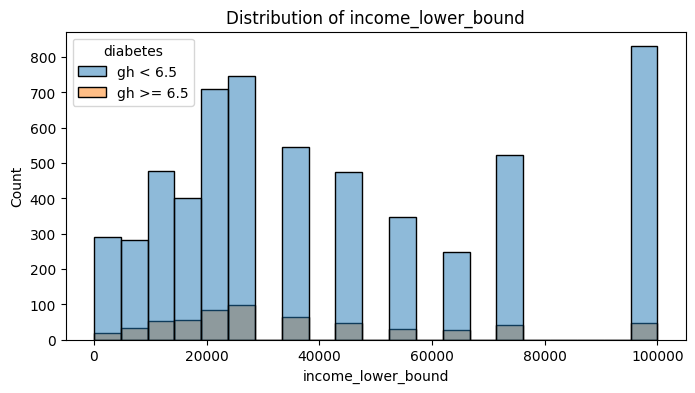

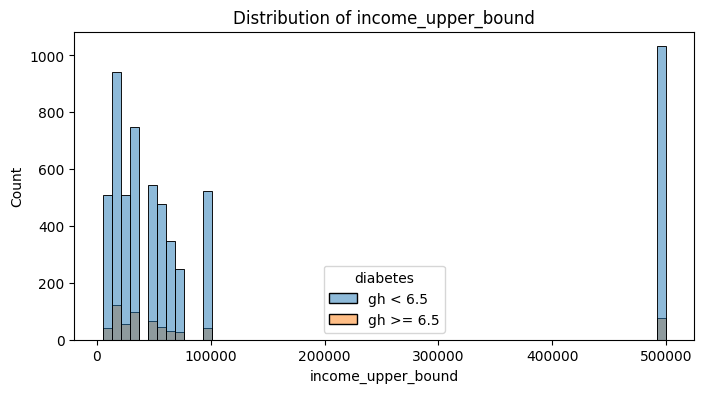

In [18]:
# Explore the distribution of numeric variables (histograms)
for feature in nhgh.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=nhgh, x=feature, hue='diabetes')
    plt.title(f'Distribution of {feature}')
    plt.show()

Comparing the distributions of diabetic (gh >= 6.5) and non-diabetic patients (gh < 6.5):
- Increased proportion/count of diabetic patients as age increases
- Expectedly, there is a higher proportion of patients with gh > 6.5 amongst those who are receiving treatment for diabetes and those who are diagnosed with DM or pre-DM.
- Distribution of height, upper arm length, upper leg length, BUN and SCr are similar
- Weight, BMI, arm circumference, waist circumference, tricep skinfold thickness (only marginally), subscapular skinfold thickness is more right-skewed for diabetic patients
- Albumin levels seems to be more left skewed in diabetic patients.

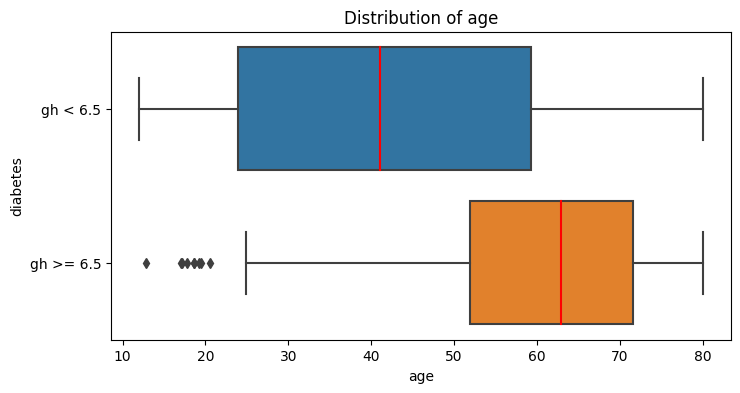

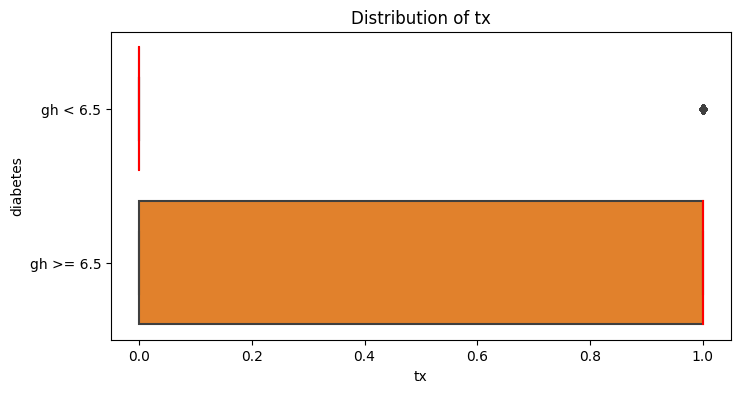

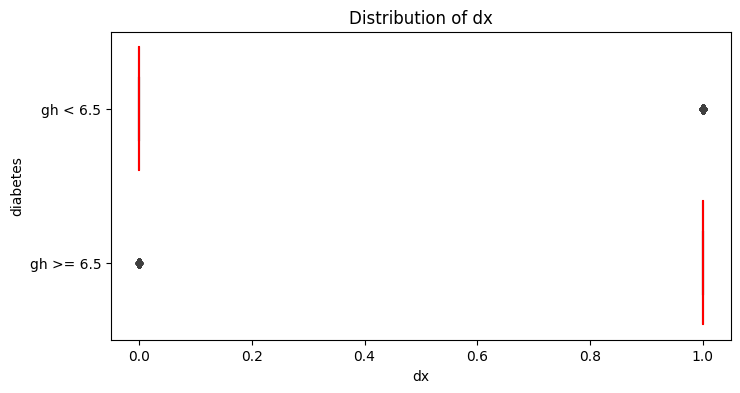

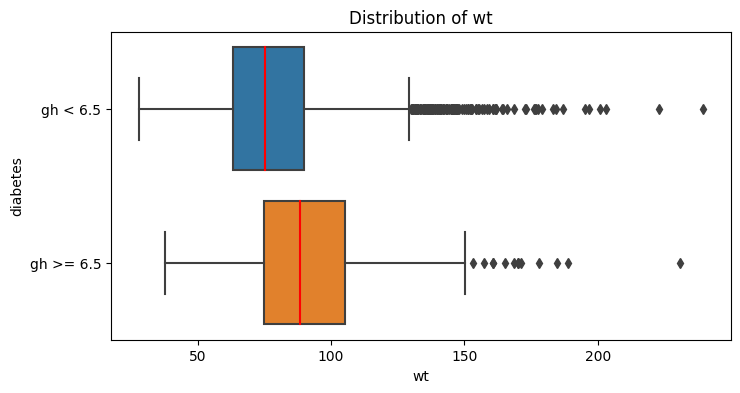

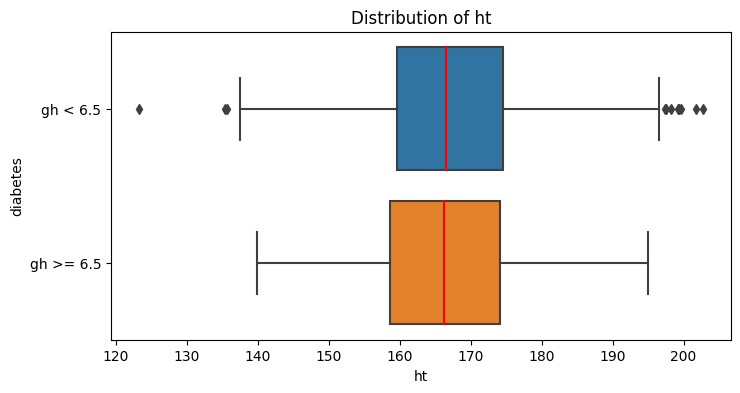

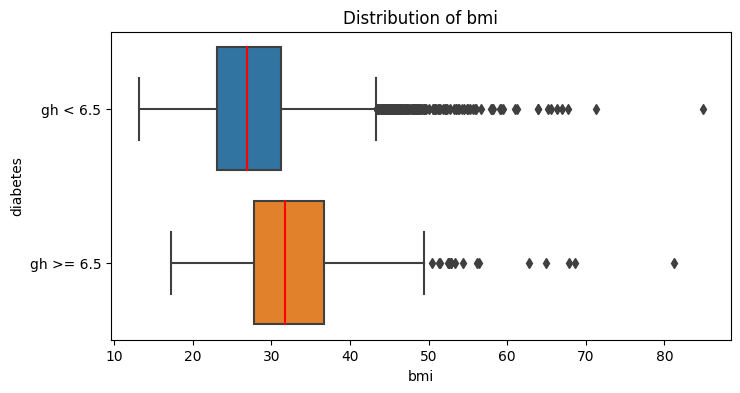

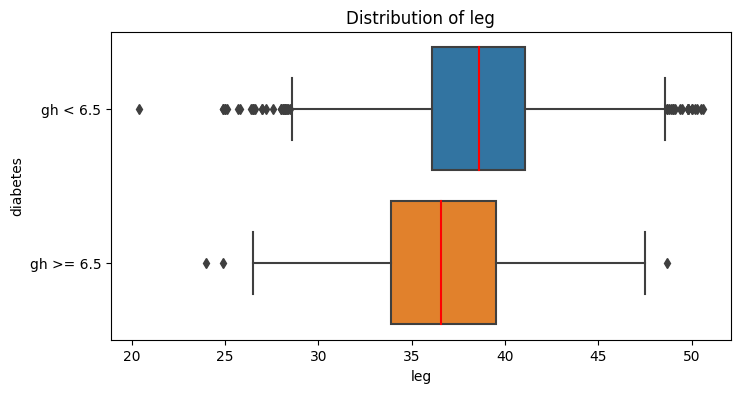

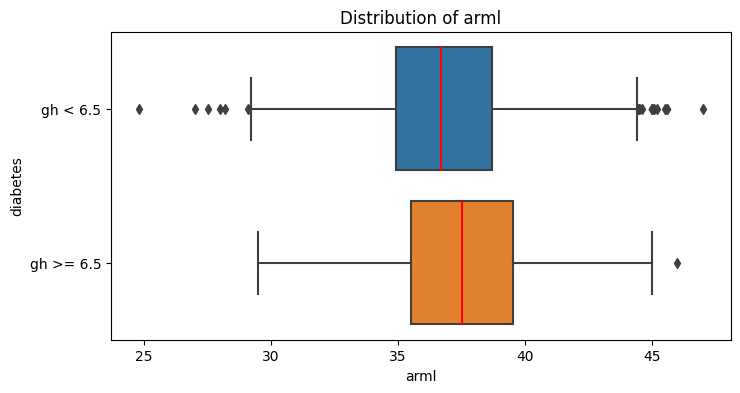

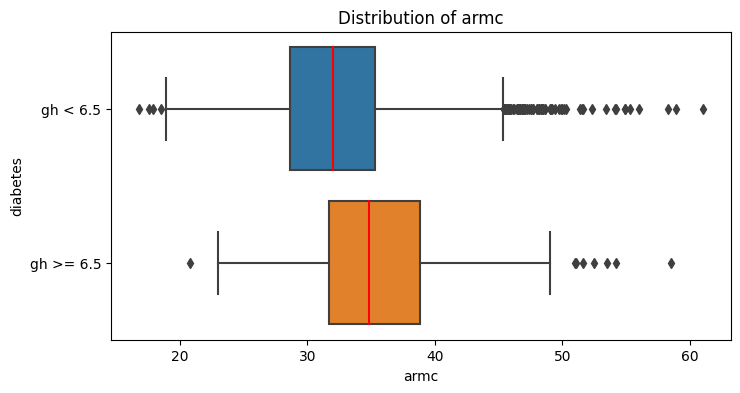

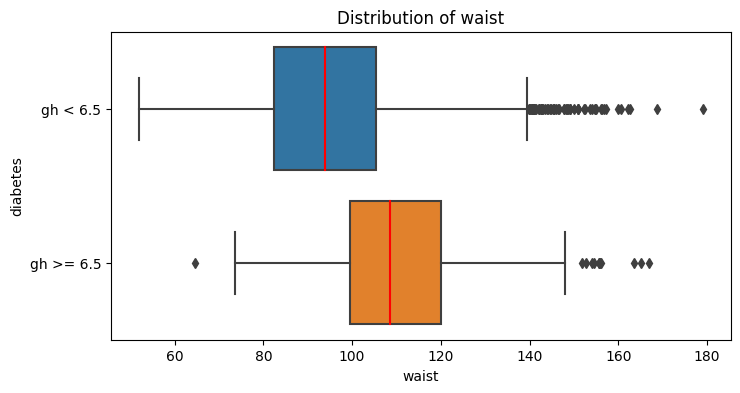

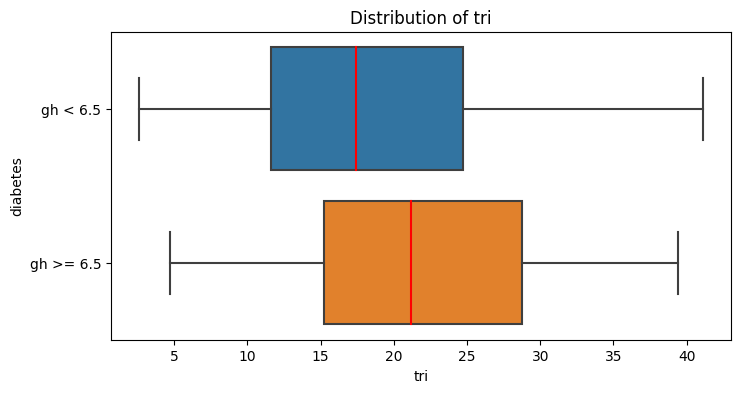

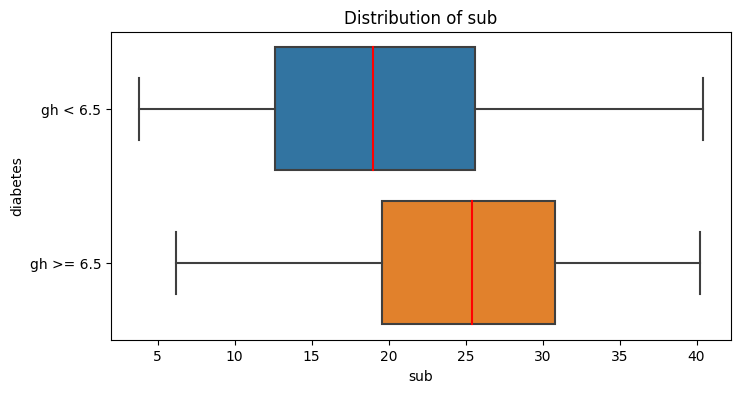

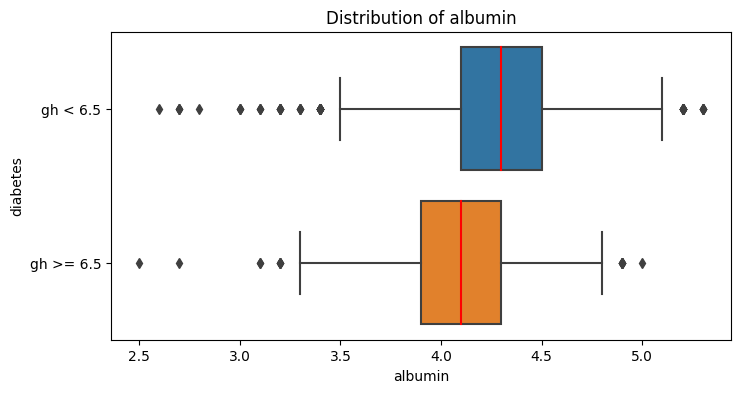

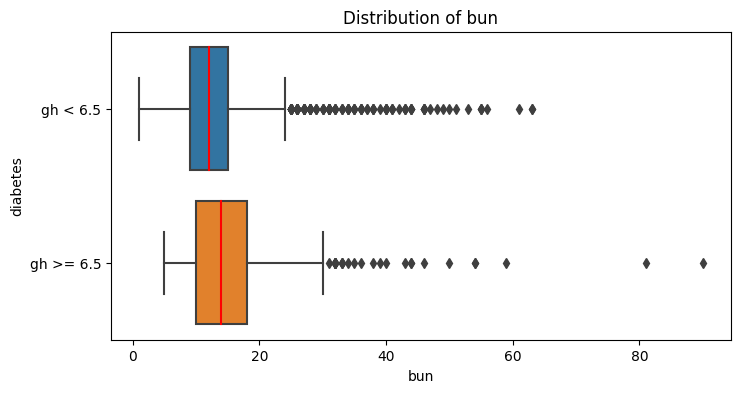

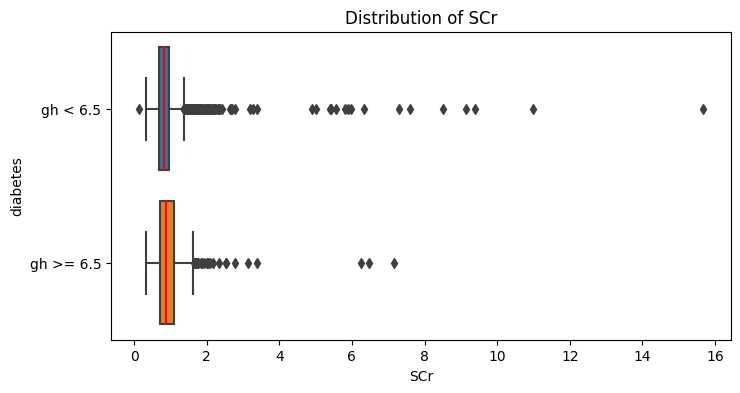

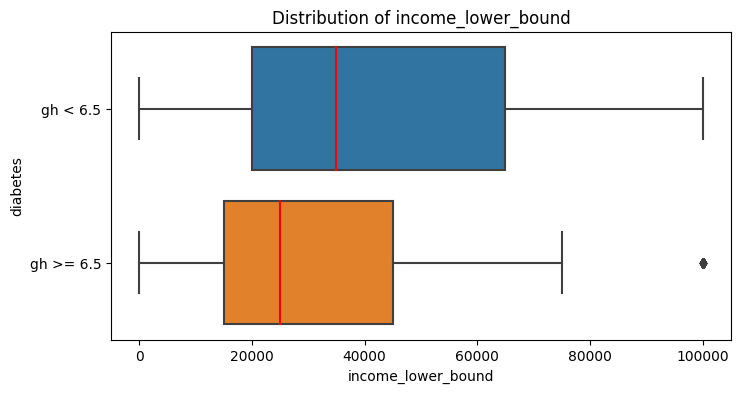

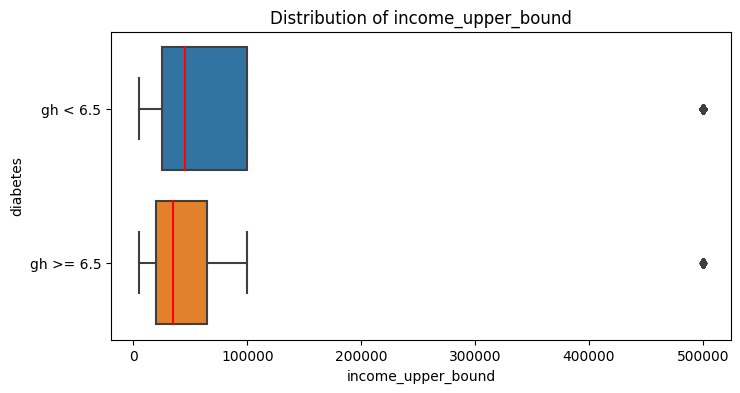

In [19]:
# Explore the distribution of numeric variables (boxplots)
for feature in nhgh.select_dtypes(include=[np.number]).columns:
    if feature != 'gh':  
        plt.figure(figsize=(8, 4))
        medianprops = {'color': 'red'}
        sns.boxplot(data=nhgh, x=feature, y='diabetes', medianprops=medianprops)
        plt.title(f'Distribution of {feature}')
        plt.show()

C:\Users\enoch\AppData\Local\Temp\ipykernel_4560\1840727251.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(nhgh.corr(), annot=True, fmt='.2g', cmap='coolwarm')


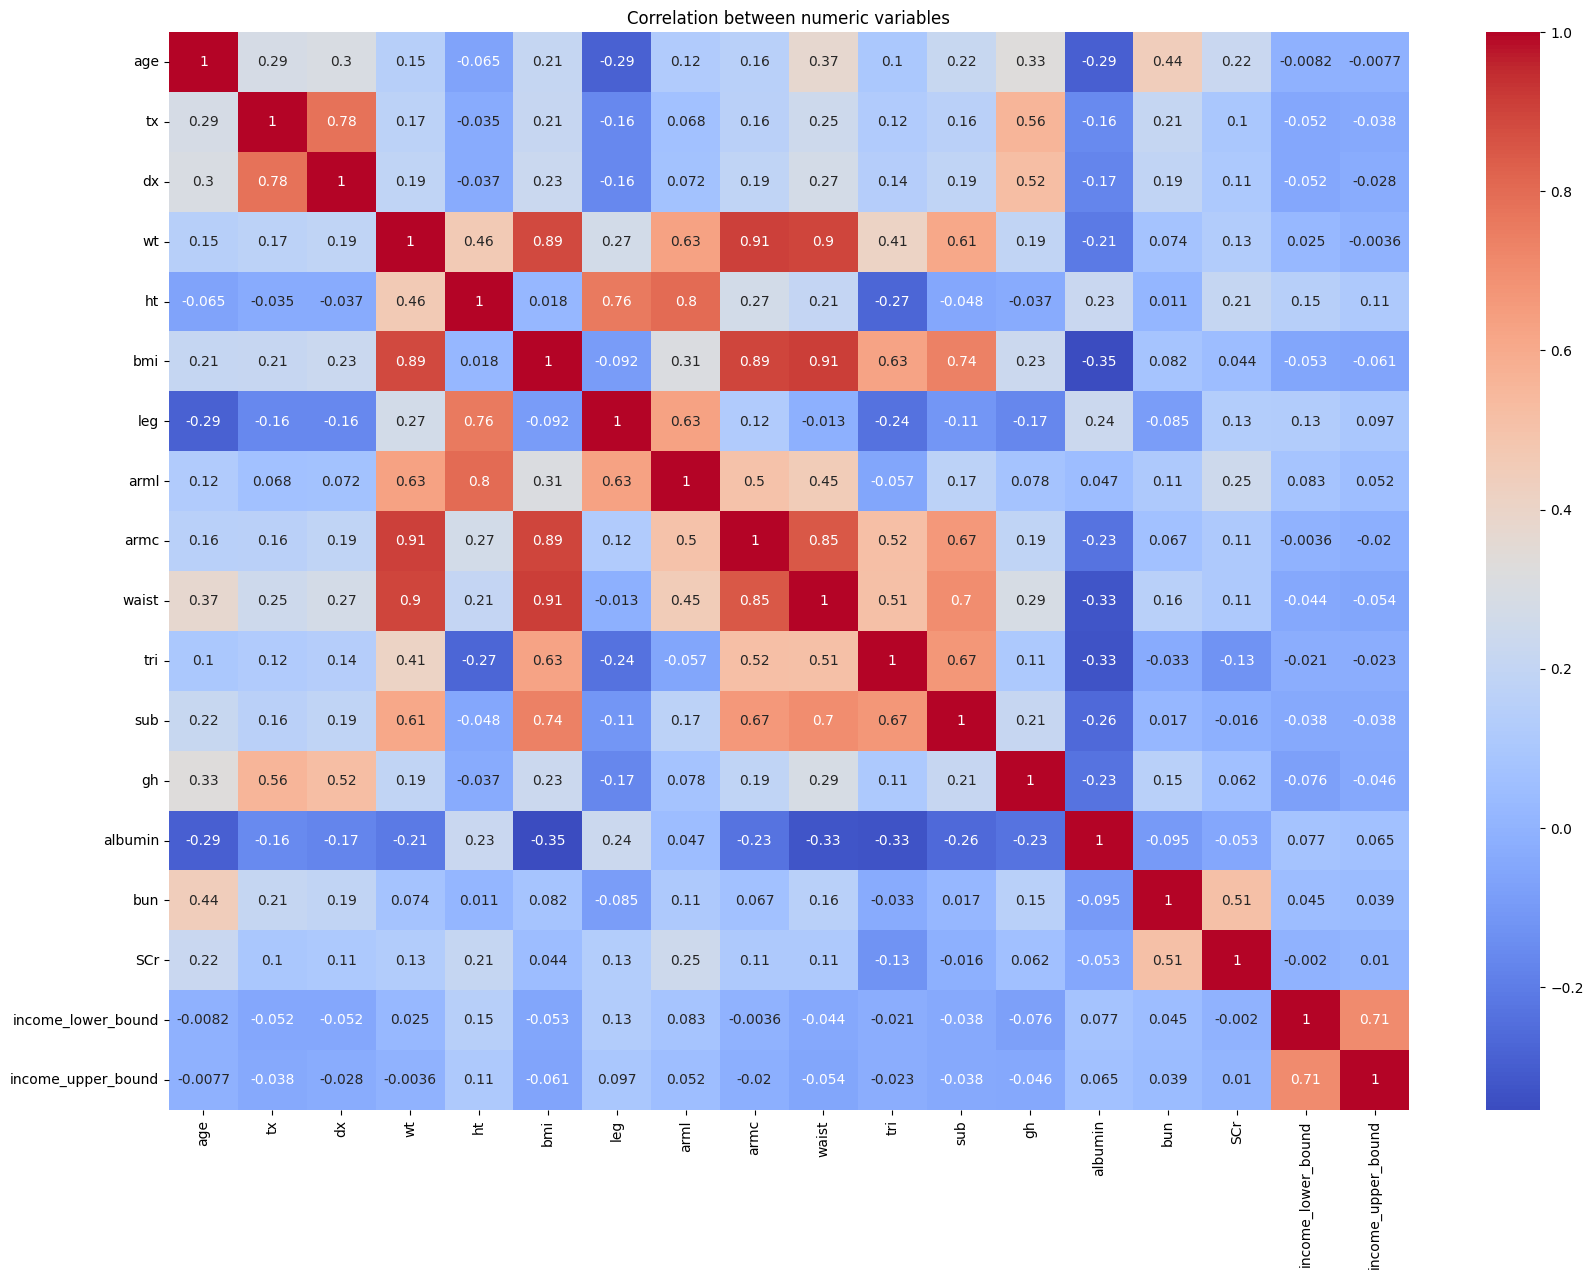

In [20]:
# Correlation heatmap
plt.figure(figsize=(20,14))
sns.heatmap(nhgh.corr(), annot=True, fmt='.2g', cmap='coolwarm')
plt.title('Correlation between numeric variables')
plt.show()

Treatment (0.56) and diagnosis (0.52) have the highest linear correlation with glycated hemoglobin (target)

- I will use 0.7 as the cutoff for features with high co-linearity, which may affect some ML models.
- Variables with high co-linearity include:
    - Treatment and diagnosis (0.78)
    - Weight and BMI (0.89)
    - Weight and arm circumference (0.91)
    - Weight and waist circumference (0.9)
    - Height and leg length (0.76)
    - Height and arm length (0.8)
    - BMI and arm circumference (0.89)
    - BMI and waist circumference (0.91)
    - BMI and subscapular skinfold (0.74)
    - Arm circumference and waist circumference (0.85)
    - Waist circumference and subscapular thickness (0.7)
    - Income upper and lower bound (0.71)

C:\Users\enoch\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


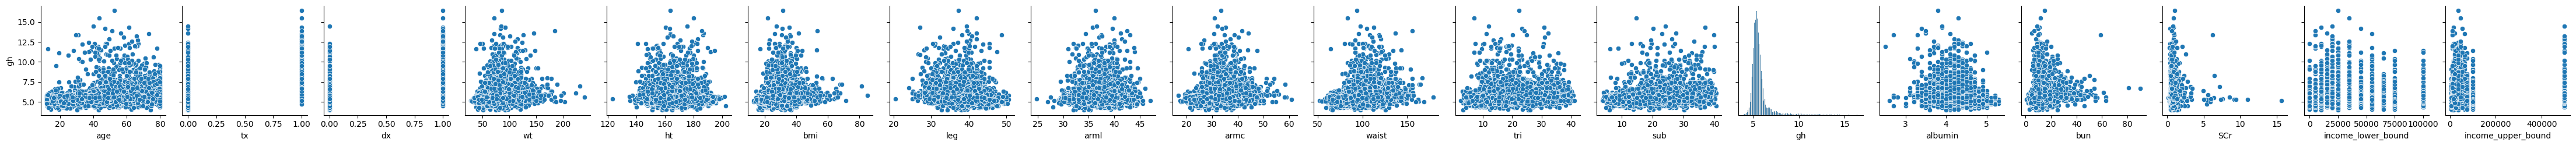

In [21]:
# Quick visualization to check for any linear relationship between numeric variables and gh
sns.pairplot(data=nhgh, y_vars='gh')

No strong linear relationships in pairplot, which is supported by the low absolute correlation scores seen in the correlation heatmap.

# Preprocessing for modelling

In [22]:
# Convert male to 0 and female to 1
nhgh['sex'] = nhgh['sex'].map(lambda x: 0 if x == 'male' else 1)

In [23]:
# Drop diabetes column
nhgh = nhgh.drop(columns='diabetes')

In [24]:
# Map gh column to 0 (gh < 6.5) and 1 (gh >= 6.5)
nhgh['gh'] = nhgh['gh'].map(lambda x: 0 if x < 6.5 else 1)

In [25]:
# Impute missing values and one hot encode categorical columns
numerical_cols = nhgh.select_dtypes(include=['number']).columns
categorical_cols = nhgh.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
data_transformed = preprocessor.fit_transform(nhgh)

In [26]:
# Get the column names after transformation
transformed_column_names = (list(numerical_cols) +
                         list(preprocessor.named_transformers_['cat']
                              .named_steps['onehot']
                              .get_feature_names_out
                              (categorical_cols)))

# Create a DataFrame for the transformed data with column names
data_transformed = pd.DataFrame(data_transformed, columns=transformed_column_names)

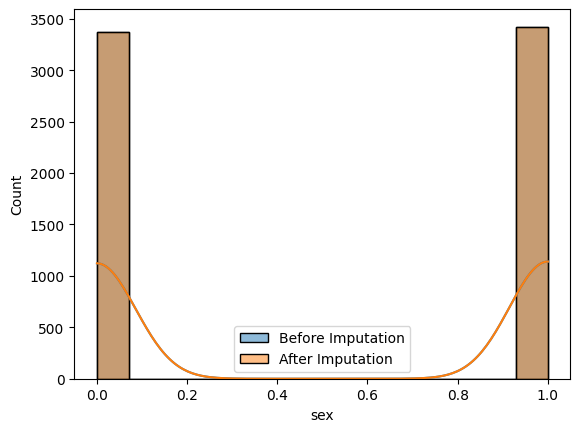

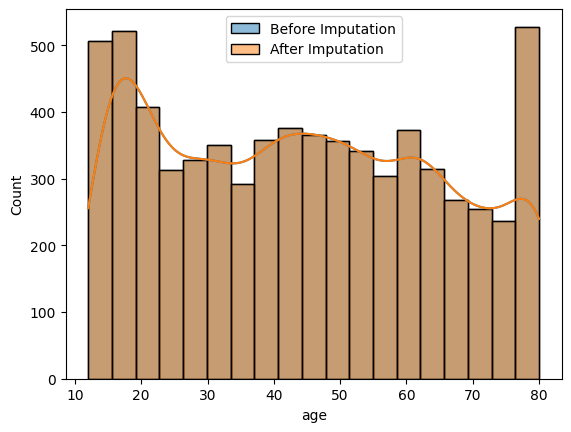

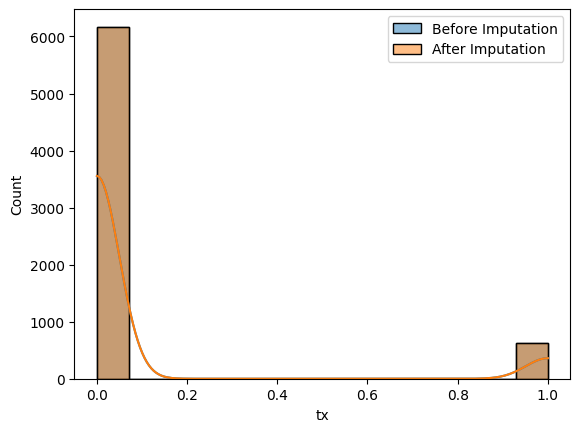

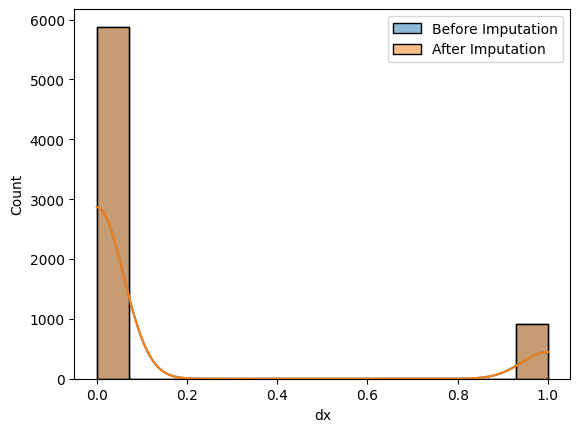

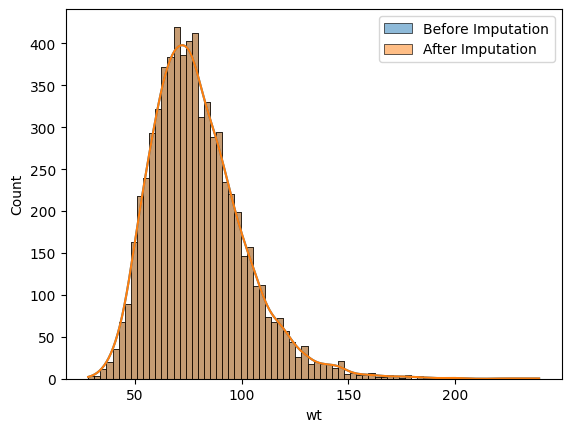

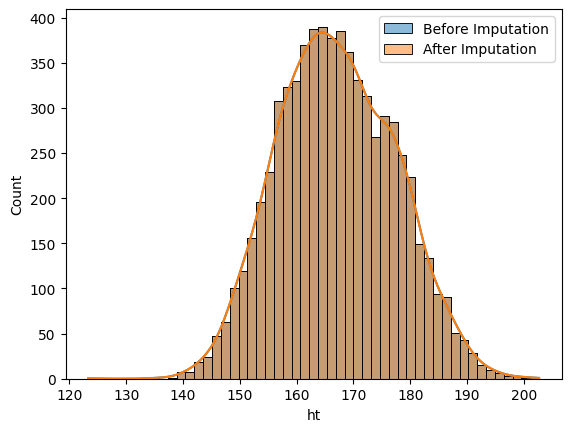

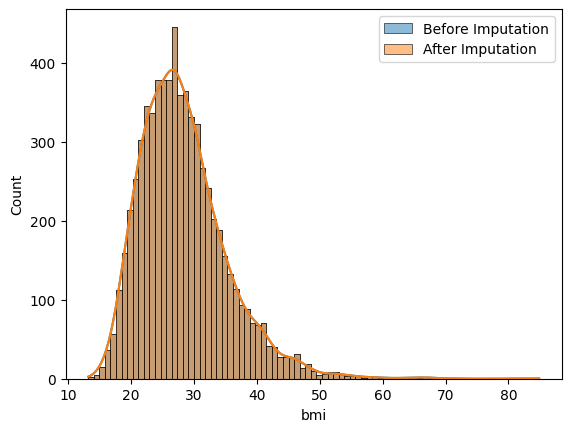

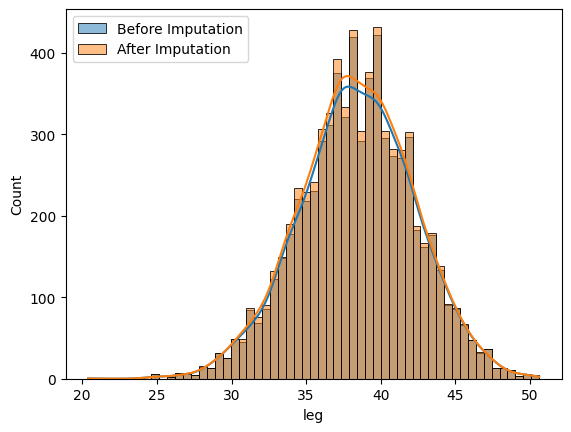

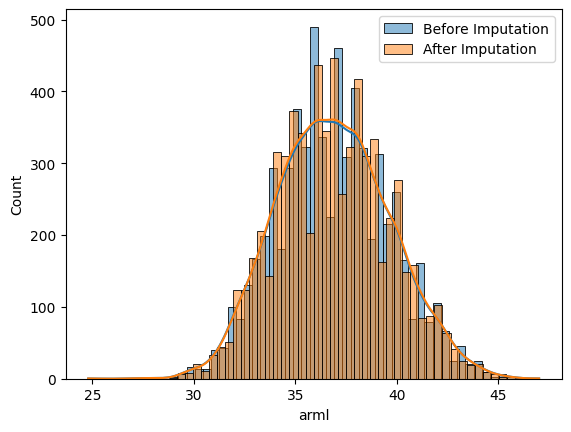

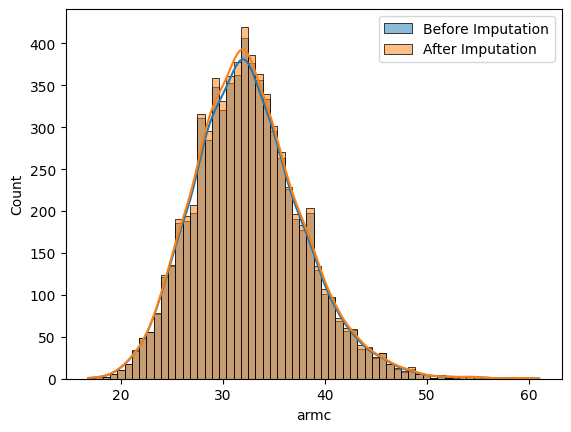

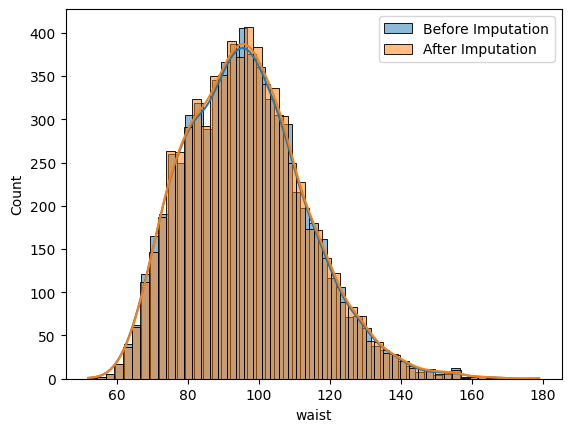

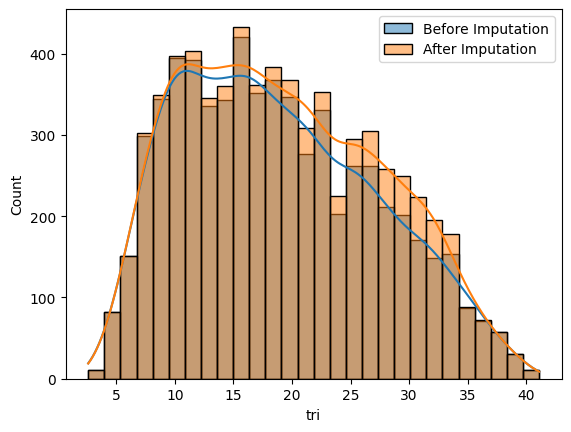

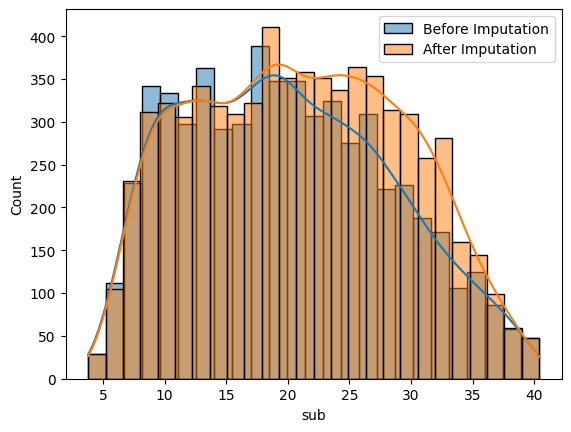

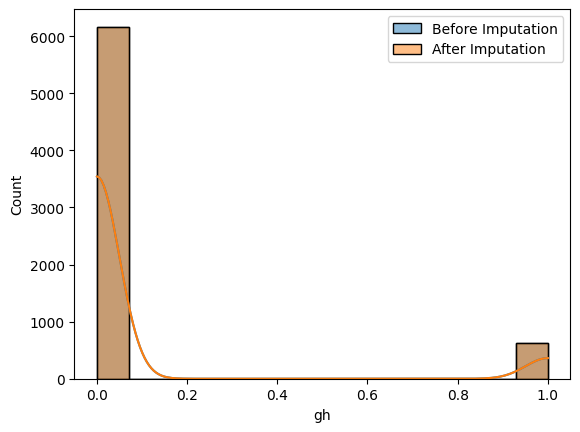

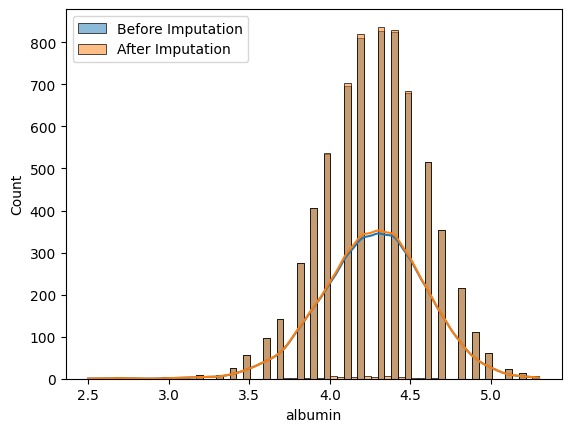

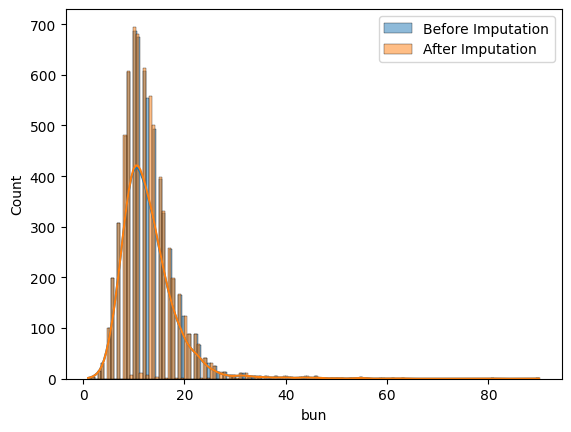

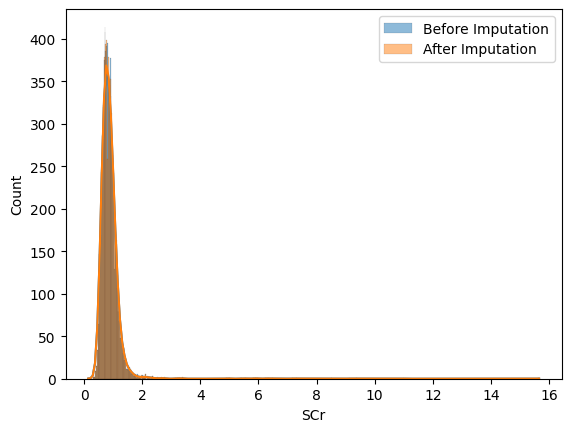

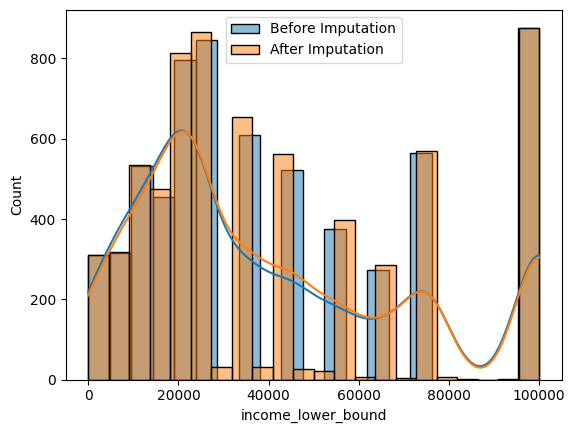

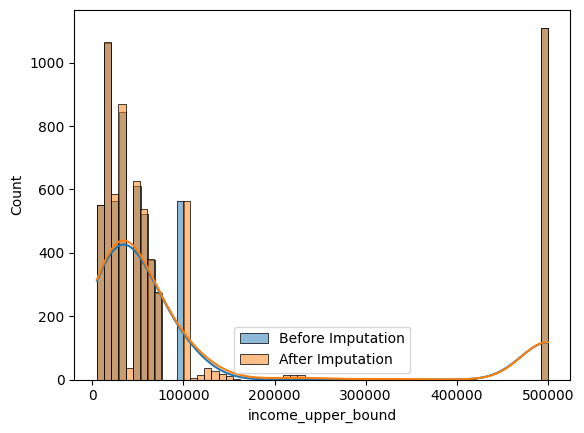

In [27]:
# Visualizing distribution of data after imputation of missing values
for column in nhgh.select_dtypes(include=['number']).columns:
    sns.histplot(data=nhgh, x=column, label='Before Imputation', kde=True)
    sns.histplot(data=data_transformed, x=column, label='After Imputation', kde=True)
    plt.legend()
    plt.show()

We can see the distribution of the data has remained roughly similar after KNN imputation.

In [28]:
# Dropping co-linear features
data_transformed = data_transformed.drop(columns=['wt', 'ht', 'armc', 'bmi', 'tri', 'sub', 'SCr',
                                                  'bun', 'income_upper_bound', 'tx'], axis=1)

In [29]:
# Split the data into features and target
X = data_transformed.drop('gh', axis=1)
y = data_transformed['gh']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6795, 13) (6795,)
(5096, 13) (1699, 13) (5096,) (1699,)


# Logistic Regression

In [30]:
# Establish pipeline and gridsearch parameters for Logistic Regression
lr_pipe = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('sampling', SMOTETomek(random_state=42)),
    ('lr', LogisticRegression(random_state=42))
])

lr_pipe_params = {
    'sampling__sampling_strategy': [1.0], # [0.9, 1.0]
    'lr__C': [0.01], # [0.01, 0.1, 0.15, 0.2, 0.5]
     'lr__penalty': ['l2'], # [None, 'l1', 'l2']
     'lr__solver': ['liblinear'] # ['liblinear', 'lbfgs', 'newton-cholesky', 'saga']
}

lr = GridSearchCV(lr_pipe, lr_pipe_params, scoring='recall', cv=5, verbose=2)

In [31]:
# Fitting of Logistic Regression Pipeline
lr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear, sampling__sampling_strategy=1.0; total time=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(random_state=42)),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             param_grid={'lr__C': [0.01], 'lr__penalty': ['l2'],
                         'lr__solver': ['liblinear'],
                         'sampling__sampling_strategy': [1.0]},
             scoring='recall', verbose=2)

In [32]:
# Print out best estimator.
lr.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0)),
                ('lr',
                 LogisticRegression(C=0.01, random_state=42,
                                    solver='liblinear'))])

In [33]:
# Print out best score.
# Mean cross-validated score of the best_estimator
print('GridSearchCV best score: {:.3f}'.format(lr.best_score_))
print('GridSearchCV best parameters: {}'.format(lr.best_params_))

GridSearchCV best score: 0.847
GridSearchCV best parameters: {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'sampling__sampling_strategy': 1.0}


In [34]:
# Making predictions
y_lr_pred = lr.predict(X_test)
y_lr_pred_proba = lr.predict_proba(X_test)

In [35]:
# Metrics
train_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_lr_pred).ravel()
spec = tn / (tn + fp)
precision = precision_score(y_test, y_lr_pred)
train_recall = recall_score(y_train, lr.predict(X_train))
recall = recall_score(y_test, y_lr_pred)
f1 = f1_score(y_test, y_lr_pred)
roc_auc = roc_auc_score(y_test, y_lr_pred_proba[:, 1])

print('Train Accuracy: {:.3f}'.format(train_accuracy))
print('Test Accuracy: {:.3f}'.format(test_accuracy))
print('Precision: {:.3f}'.format(precision))
print('Train Recall: {:.3f}'.format(train_recall))
print('Test Recall: {:.3f}'.format(recall))
print('Specificity: {:.3f}'.format(spec))
print('F1 score: {:.3f}'.format(f1))
print('ROC AUC: {:.3f}'.format(roc_auc))

Train Accuracy: 0.834
Test Accuracy: 0.866
Precision: 0.446
Train Recall: 0.834
Test Recall: 0.866
Specificity: 0.890
F1 score: 0.589
ROC AUC: 0.935


In [36]:
# ROC-AUC
y_lr_pred_proba_train = lr.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, y_lr_pred_proba_train[:,1])
auc_score_test = roc_auc_score(y_test, y_lr_pred_proba[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, lr.predict(X_test)))

ROC-AUC on training set: 0.9319515694037986
ROC-AUC on testing set: 0.9348228374102621

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94      1542
         1.0       0.45      0.87      0.59       157

    accuracy                           0.89      1699
   macro avg       0.72      0.88      0.76      1699
weighted avg       0.94      0.89      0.90      1699



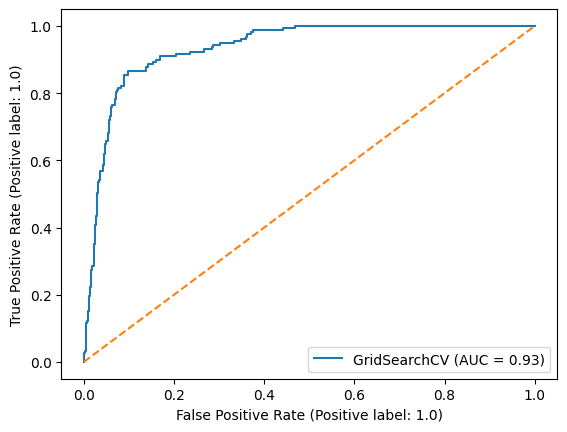

In [37]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

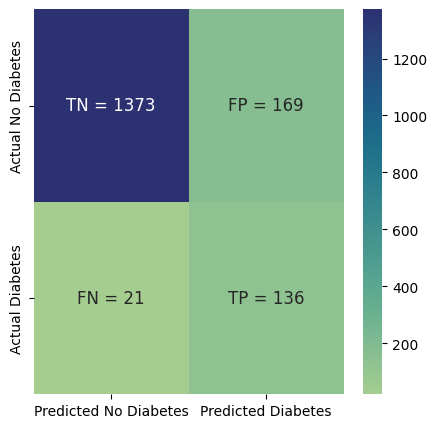

In [38]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test, y_lr_pred)
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(5,5))
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['Predicted No Diabetes', 'Predicted Diabetes'],
    yticklabels=['Actual No Diabetes', 'Actual Diabetes']
)

# RandomForest Classifier

In [39]:
# Establish pipeline and gridsearch parameters for Logistic Regression
rf_pipe = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('sampling', SMOTETomek(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_pipe_params = {
    'sampling__sampling_strategy': [1.0], # [0.9, 1.0]
    'rf__n_estimators': [100], # [50, 100, 200, 300]
    'rf__max_depth': [16], #[8, 16, 24, 32]
    'rf__min_samples_split': [2],
    'rf__min_samples_leaf': [0.02], #[0.01, 0.02, 0.03]
    'rf__criterion': ['gini'], # ['gini','entropy', 'log_loss']
    'rf__max_features': [None] # ['sqrt','log2', None]
}

rf = GridSearchCV(rf_pipe, rf_pipe_params, scoring='recall', cv=5, verbose=2)

In [40]:
# Fitting of Logistic Regression Pipeline
rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END rf__criterion=gini, rf__max_depth=16, rf__max_features=None, rf__min_samples_leaf=0.02, rf__min_samples_split=2, rf__n_estimators=100, sampling__sampling_strategy=1.0; total time=   0.3s
[CV] END rf__criterion=gini, rf__max_depth=16, rf__max_features=None, rf__min_samples_leaf=0.02, rf__min_samples_split=2, rf__n_estimators=100, sampling__sampling_strategy=1.0; total time=   0.2s
[CV] END rf__criterion=gini, rf__max_depth=16, rf__max_features=None, rf__min_samples_leaf=0.02, rf__min_samples_split=2, rf__n_estimators=100, sampling__sampling_strategy=1.0; total time=   0.2s
[CV] END rf__criterion=gini, rf__max_depth=16, rf__max_features=None, rf__min_samples_leaf=0.02, rf__min_samples_split=2, rf__n_estimators=100, sampling__sampling_strategy=1.0; total time=   0.2s
[CV] END rf__criterion=gini, rf__max_depth=16, rf__max_features=None, rf__min_samples_leaf=0.02, rf__min_samples_split=2, rf__n_estimators=100, sampling__sam

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'rf__criterion': ['gini'], 'rf__max_depth': [16],
                         'rf__max_features': [None],
                         'rf__min_samples_leaf': [0.02],
                         'rf__min_samples_split': [2],
                         'rf__n_estimators': [100],
                         'sampling__sampling_strategy': [1.0]},
             scoring='recall', verbose=2)

In [41]:
# Print out best estimator.
rf.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0)),
                ('rf',
                 RandomForestClassifier(max_depth=16, max_features=None,
                                        min_samples_leaf=0.02, n_jobs=-1,
                                        random_state=42))])

In [42]:
# Print out best score.
# Mean cross-validated score of the best_estimator
print('GridSearchCV best score: {:.3f}'.format(rf.best_score_))
print('GridSearchCV best parameters: {}'.format(rf.best_params_))

GridSearchCV best score: 0.822
GridSearchCV best parameters: {'rf__criterion': 'gini', 'rf__max_depth': 16, 'rf__max_features': None, 'rf__min_samples_leaf': 0.02, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'sampling__sampling_strategy': 1.0}


In [43]:
# Making predictions
y_rf_pred = rf.predict(X_test)
y_rf_pred_proba = rf.predict_proba(X_test)

In [44]:
# Metrics
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_rf_pred).ravel()
spec = tn / (tn + fp)
precision = precision_score(y_test, y_rf_pred)
train_recall = recall_score(y_train, rf.predict(X_train))
recall = recall_score(y_test, y_rf_pred)
f1 = f1_score(y_test, y_rf_pred)
roc_auc = roc_auc_score(y_test, y_rf_pred_proba[:, 1])

print('Train Accuracy: {:.3f}'.format(train_accuracy))
print('Test Accuracy: {:.3f}'.format(test_accuracy))
print('Precision: {:.3f}'.format(precision))
print('Train Recall: {:.3f}'.format(train_recall))
print('Test Recall: {:.3f}'.format(recall))
print('Specificity: {:.3f}'.format(spec))
print('F1 score: {:.3f}'.format(f1))
print('ROC AUC: {:.3f}'.format(roc_auc))

Train Accuracy: 0.858
Test Accuracy: 0.866
Precision: 0.412
Train Recall: 0.858
Test Recall: 0.866
Specificity: 0.874
F1 score: 0.559
ROC AUC: 0.925


In [45]:
# ROC-AUC
y_rf_pred_proba_train = rf.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, y_rf_pred_proba_train[:,1])
auc_score_test = roc_auc_score(y_test, y_rf_pred_proba[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, rf.predict(X_test)))

ROC-AUC on training set: 0.9326514029953521
ROC-AUC on testing set: 0.9251282559666906

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.93      1542
         1.0       0.41      0.87      0.56       157

    accuracy                           0.87      1699
   macro avg       0.70      0.87      0.74      1699
weighted avg       0.93      0.87      0.89      1699



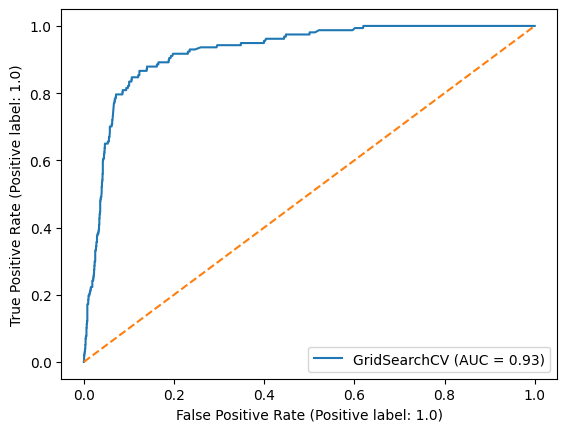

In [46]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

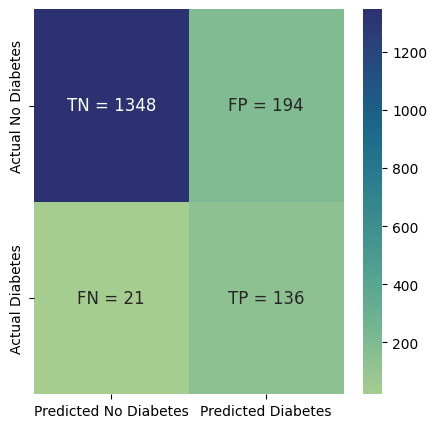

In [47]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test, y_rf_pred)
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(5,5))
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['Predicted No Diabetes', 'Predicted Diabetes'],
    yticklabels=['Actual No Diabetes', 'Actual Diabetes']
)

In [48]:
# Create a DataFrame for feature importance
coef = rf.best_estimator_['rf'].feature_importances_
feature = rf.best_estimator_['ss'].get_feature_names_out()
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

<Axes: xlabel='Importance', ylabel='Features'>

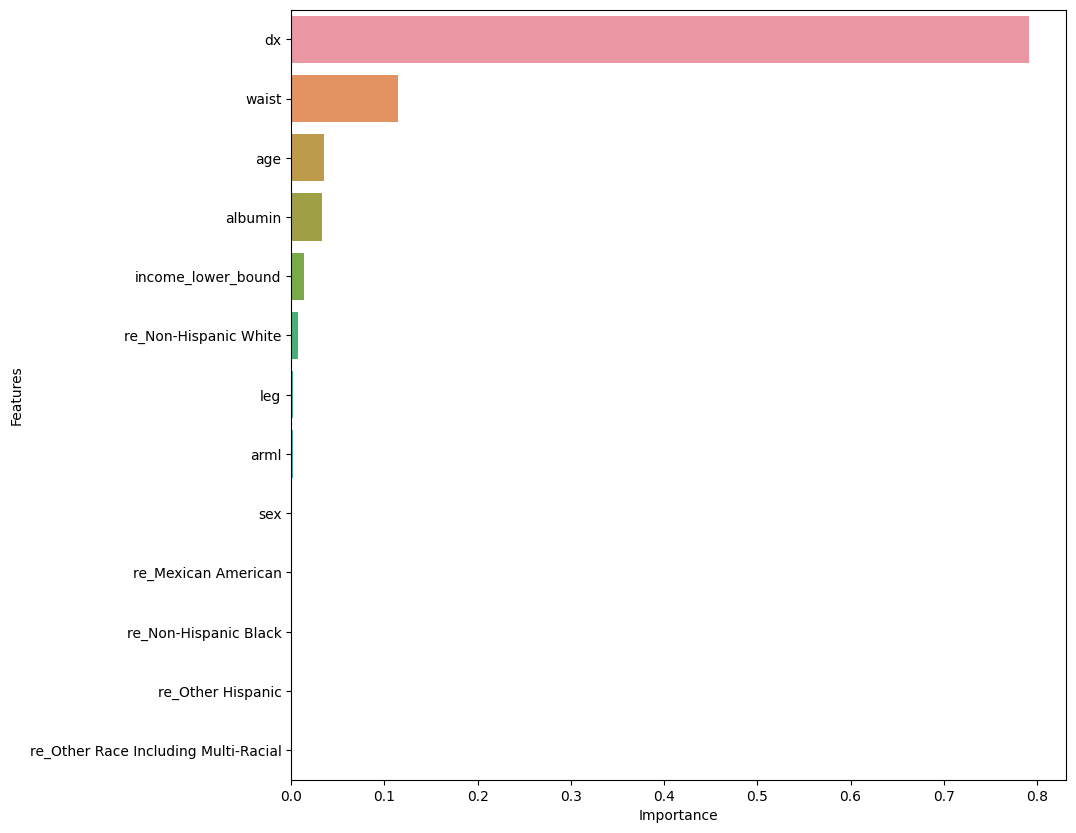

In [49]:
# Plotting feature importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=feature_importance, x='Importance',y='Features',
            orient='h', ax=axes)

# Decision Tree Classifier

In [50]:
# Establish pipeline and gridsearch parameters for Logistic Regression
dt_pipe = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('sampling', SMOTETomek(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

dt_pipe_params = {
    'sampling__sampling_strategy': [1.0], # [0.5, 0.8, 1.0]
    'dt__splitter': ['random'], # ['best', 'random']
    'dt__max_depth': [16], # [16, 24, 32, 40]
    'dt__min_samples_split': [2],
    'dt__min_samples_leaf': [0.01], # [0.01, 0.015, 0.02]
    'dt__criterion': ['gini'], # ['gini','entropy', 'log_loss']
    'dt__max_features': [1.0] # [0.7, 0.8, 0.9, 1.0]
}

dt = GridSearchCV(dt_pipe, dt_pipe_params, scoring='recall', cv=5, verbose=2)

In [51]:
# Fitting of Logistic Regression Pipeline
dt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END dt__criterion=gini, dt__max_depth=16, dt__max_features=1.0, dt__min_samples_leaf=0.01, dt__min_samples_split=2, dt__splitter=random, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=16, dt__max_features=1.0, dt__min_samples_leaf=0.01, dt__min_samples_split=2, dt__splitter=random, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=16, dt__max_features=1.0, dt__min_samples_leaf=0.01, dt__min_samples_split=2, dt__splitter=random, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=16, dt__max_features=1.0, dt__min_samples_leaf=0.01, dt__min_samples_split=2, dt__splitter=random, sampling__sampling_strategy=1.0; total time=   0.0s
[CV] END dt__criterion=gini, dt__max_depth=16, dt__max_features=1.0, dt__min_samples_leaf=0.01, dt__min_samples_split=2, dt__splitter=random, sampling__sampling_stra

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('sampling',
                                        SMOTETomek(random_state=42)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini'], 'dt__max_depth': [16],
                         'dt__max_features': [1.0],
                         'dt__min_samples_leaf': [0.01],
                         'dt__min_samples_split': [2],
                         'dt__splitter': ['random'],
                         'sampling__sampling_strategy': [1.0]},
             scoring='recall', verbose=2)

In [52]:
# Print out best estimator.
dt.best_estimator_

Pipeline(steps=[('ss', StandardScaler()),
                ('sampling',
                 SMOTETomek(random_state=42, sampling_strategy=1.0)),
                ('dt',
                 DecisionTreeClassifier(max_depth=16, max_features=1.0,
                                        min_samples_leaf=0.01, random_state=42,
                                        splitter='random'))])

In [53]:
# Print out best score.
# Mean cross-validated score of the best_estimator
print('GridSearchCV best score: {:.3f}'.format(dt.best_score_))
print('GridSearchCV best parameters: {}'.format(dt.best_params_))

GridSearchCV best score: 0.836
GridSearchCV best parameters: {'dt__criterion': 'gini', 'dt__max_depth': 16, 'dt__max_features': 1.0, 'dt__min_samples_leaf': 0.01, 'dt__min_samples_split': 2, 'dt__splitter': 'random', 'sampling__sampling_strategy': 1.0}


In [54]:
# Making predictions
y_dt_pred = dt.predict(X_test)
y_dt_pred_proba = dt.predict_proba(X_test)

In [55]:
# Metrics
train_accuracy = dt.score(X_train, y_train)
test_accuracy = dt.score(X_test, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_dt_pred).ravel()
spec = tn / (tn + fp)
precision = precision_score(y_test, y_dt_pred)
train_recall = recall_score(y_train, dt.predict(X_train))
recall = recall_score(y_test, y_dt_pred)
f1 = f1_score(y_test, y_dt_pred)
roc_auc = roc_auc_score(y_test, y_dt_pred_proba[:, 1])

print('Train Accuracy: {:.3f}'.format(train_accuracy))
print('Test Accuracy: {:.3f}'.format(test_accuracy))
print('Precision: {:.3f}'.format(precision))
print('Train Recall: {:.3f}'.format(train_recall))
print('Test Recall: {:.3f}'.format(recall))
print('Specificity: {:.3f}'.format(spec))
print('F1 score: {:.3f}'.format(f1))
print('ROC AUC: {:.3f}'.format(roc_auc))

Train Accuracy: 0.839
Test Accuracy: 0.822
Precision: 0.429
Train Recall: 0.839
Test Recall: 0.822
Specificity: 0.888
F1 score: 0.563
ROC AUC: 0.922


In [56]:
# ROC-AUC
y_dt_pred_proba_train = dt.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, y_dt_pred_proba_train[:,1])
auc_score_test = roc_auc_score(y_test, y_dt_pred_proba[:,1])
print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')

print()
# classification report
print(classification_report(y_test, y_dt_pred))

ROC-AUC on training set: 0.9313378091467263
ROC-AUC on testing set: 0.9215428717770783

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      1542
         1.0       0.43      0.82      0.56       157

    accuracy                           0.88      1699
   macro avg       0.70      0.86      0.75      1699
weighted avg       0.93      0.88      0.90      1699



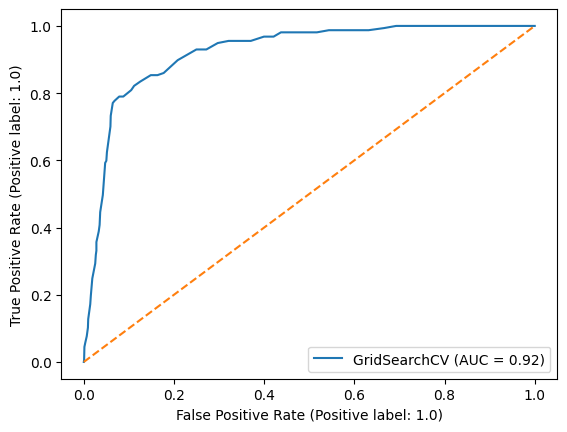

In [57]:
# plot roc curve
roc_display = RocCurveDisplay.from_estimator(dt, X_test, y_test)
plt.plot([0,1],[0,1],label='baseline',linestyle='--')

<Axes: >

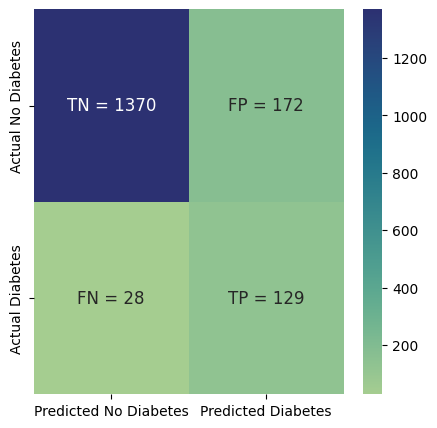

In [58]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test, y_dt_pred)
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    elif index == 1:
        cm_label.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])

plt.figure(figsize=(5,5))
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=['Predicted No Diabetes', 'Predicted Diabetes'],
    yticklabels=['Actual No Diabetes', 'Actual Diabetes']
)

In [59]:
# Create a DataFrame for feature importance
coef = dt.best_estimator_['dt'].feature_importances_
feature = dt.best_estimator_['ss'].get_feature_names_out()
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

<Axes: xlabel='Importance', ylabel='Features'>

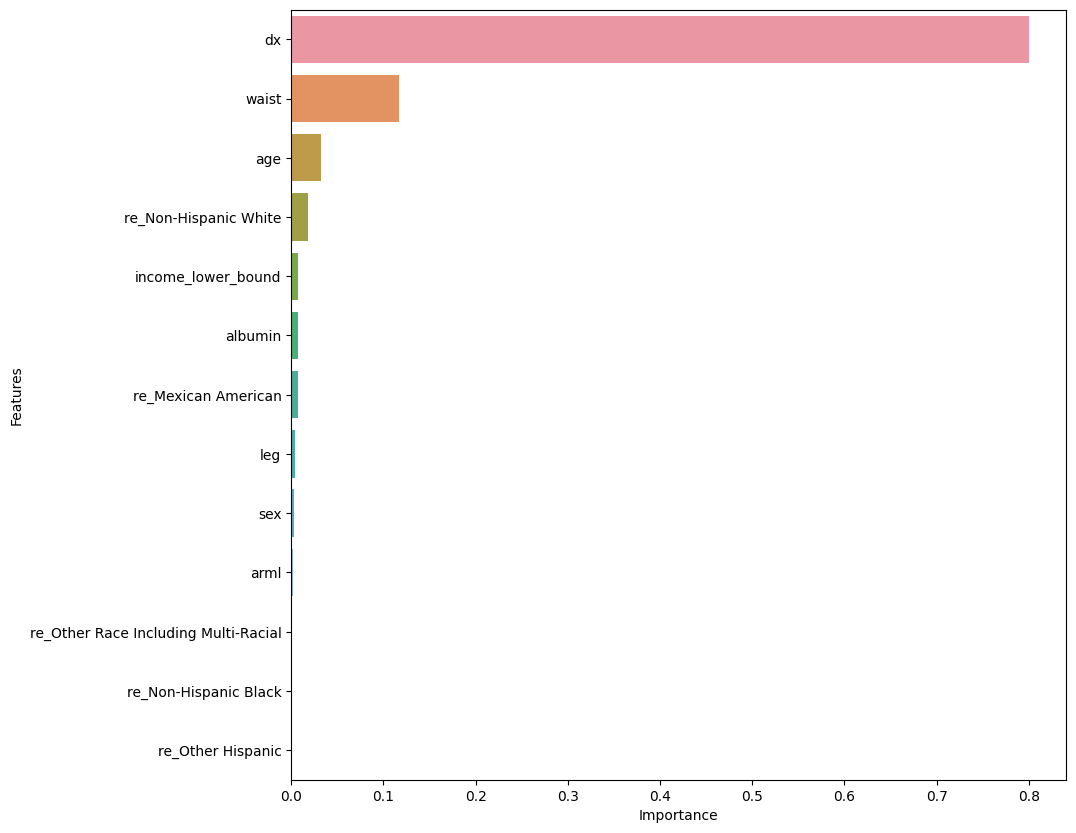

In [60]:
# Plotting feature importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=feature_importance, x='Importance',y='Features',
            orient='h', ax=axes)

# Comparing the models

| Model                     | Train Recall Score | Test Recall Score |
|---------------------------|--------------------|-------------------|
| Logistic Regression       | 0.83               | 0.87              |
| Random Forest Classifier  | 0.86               | 0.87              |
| Decision Tree Classifier  | 0.84               | 0.82              |

Choice of metric
- I have chosen to optimize recall given that we most likely want to minimize the false negatives (predicting no diabetes when the person actually has diabetes).

Comparison of models
- There is no significant overfitting amongst the models. The Decision Tree's slightly lower test recall score might indicate a bit of overfitting.
- Both Logistic Regression and Random Forest Classifier have the highest test recall score, indicating they perform better than the decision tree classifier.
- In fact, the Logistic Regression model achieves marginally better f1 and ROC-AUC scores compared to Random Forest, which represents that Logistic Regression may be better at distinguishing between the positive and negative classes.

Feature selection
- I dropped many co-linear variables with no significant impact on the model's performance.
    - Weight
    - Height
    - Arm circumference
    - BMI
    - Tricep thickness
    - Subscapular thickness
    - Serum Creatinine
    - Blood urea nitrogen
    - Upper bound income
    - Treatment

# Appendix
- Given that one of the skills to be shown was relational database knowledge, I will be using a snippet of exporting a table to a SQLite3 database and using SQL statements within pandas for visualization purposes.
- Note that these are just additional steps and are not required for the analysis.

In [61]:
# Import sqlite3
import sqlite3

In [62]:
# Importing the data
nhgh = pd.read_csv('./nhgh.tsv', sep='\t')

In [63]:
# Connect to the SQLite3 database
connection = sqlite3.connect('nhgh.db')

# Export nhgh dataframe to SQLite3 database
nhgh.to_sql('respondents', connection, if_exists='replace')

6795

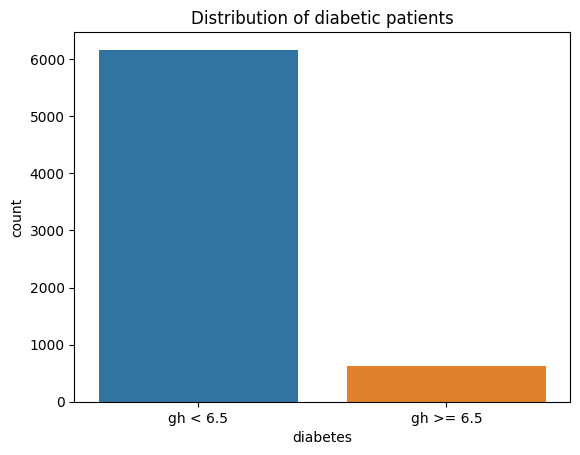

In [64]:
# Execute SQL to count occurrences of each 'diabetes' category
count_query = '''
SELECT
    CASE
        WHEN gh >= 6.5 THEN 'gh >= 6.5'
        ELSE 'gh < 6.5'
            END AS diabetes,
    COUNT(*) AS count
FROM
    respondents
GROUP BY
    diabetes;
'''

result = pd.read_sql(count_query, connection)

# Create countplot using Seaborn
sns.barplot(x='diabetes', y='count', data=result)
plt.title('Distribution of diabetic patients')
plt.show()

In [65]:
# Close the database connection
connection.close()